# Gaussian Mixture Model
This tutorial demonstrates how to marginalize out discrete latent variables in Pyro through the motivating example of a mixture model. We'll focus on the mechanics of parallel enumeration, keeping the model simple by a training a trivial 1-D Gaussian model on a tiny 5-point dataset.

In [2]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)

## Overview
Pyro’s `TraceEnum_ELBO` can automatically marginalize out variables in both the guide and the model. When enumerating guide variables, Pyro can either enumerate sequentially (which is useful if the variables determine downstream control flow), or enumerate in parallel by allocating a new tensor dimension and using nonstandard evaluation to create a tensor of possible values at the variable’s sample site. These nonstandard values are then replayed in the model. When enumerating variables in the model, the variables must be enumerated in parallel and must not appear in the guide. Mathematically, guide-side enumeration simply reduces variance in a stochastic ELBO by enumerating all values, whereas model-side enumeration avoids an application of Jensen’s inequality by exactly marginalizing out a variable.

Here is our tiny dataset. It has five points.

In [3]:
data = torch.tensor([0., 1., 10., 11., 12])

## Training a MAP estimator
Let’s start by learning model parameters `weights`, `locs`, and `scale` given priors and data. We will learn point estimates of these using an AutoDelta guide (named after its delta distributions). Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components. During inference, `TraceEnum_ELBO` will marginalize out the assignments of datapoints to clusters.

In [4]:
K = 2 # Fixed number of components.
@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
        
    with pyro.plate('data', len(data)):
        # Local variables
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)
        
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

To run inference with this `(model, guide)` pair, we use Pyro's `config_enumerate()` handler to enumerate over all assignment in each iteration. Since we've wrapped the batched Categorical assignments in a `pyro.plate` independence context, this enumeration can happen in parallel: we enumerate only 2 possibilities, rather than `2**len(data)=32`. FInally, to use the parallel version of enumeration, we inform Pyro that we are only using a single `plate` via `max_plate_nesting=1`; this lets Pyro know that we're using the rightmost dimension `plate` and that Pyro can use any other dimension for parallelisation.

In [5]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas':[0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

Before inference we'll initialize to plausible values. Mixture models are very succeptible to local modes. A common approach is choose the best among many random initializations, where the cluster means are initialized from random subsamples of the data. Since we are using an `AutoDelta` guide, we can initialize one parameter for each variable, where the name is prefixed by `auto_` and the constraint is appropriate for each distribution (you can find constraint from the `Distribution.support` attribute)

In [6]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 7, initial_loss = 25.665584564208984


During training, we'll collect both losses and gradient norms to monitor convergence. We can do this using PyTorch's `.register_hook()` method.

In [7]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
    
losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

Text(0.5, 1.0, 'Convergence of SVI')

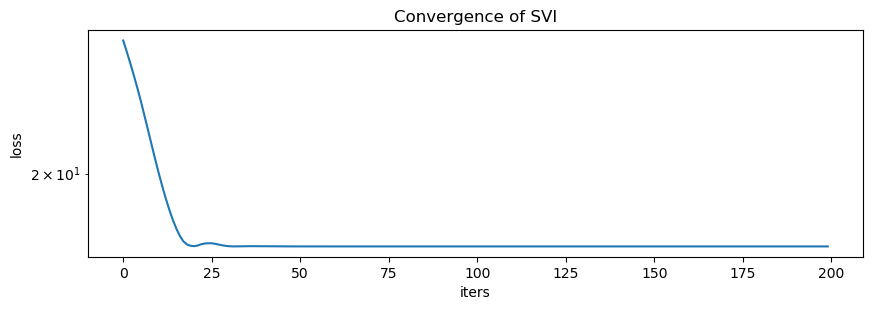

In [8]:
plt.figure(figsize=(10, 3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')

Text(0.5, 1.0, 'Gradient norms during SVI')

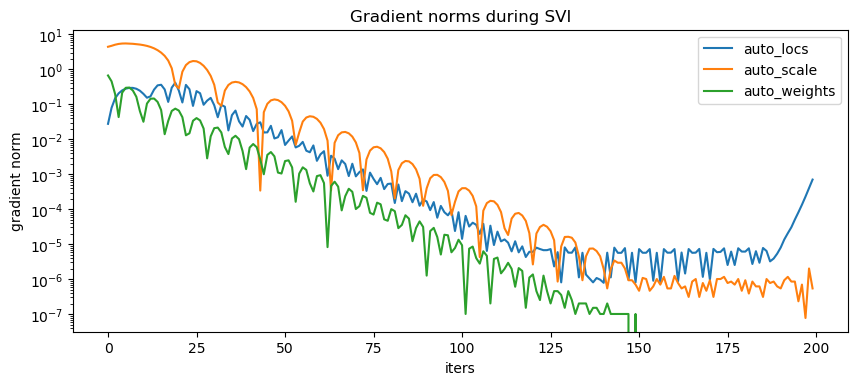

In [9]:
plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')

for name, grad_norms in gradient_norms.items():
    plt.plot(grad_norms, label=name)
    
plt.xlabel('iters')
plt.ylabel('gradient norm')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Gradient norms during SVI')

Here are the learned parameters:

In [10]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']

print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.375 0.625]
locs = [ 0.49867362 10.984463  ]
scale = 0.6514336466789246


The model's `weights` are as expected, with about 2/5 of the data in the first component and 3/5 in the second component. Now let's visualise the mixture model.

Text(0, 0.5, 'Probability density')

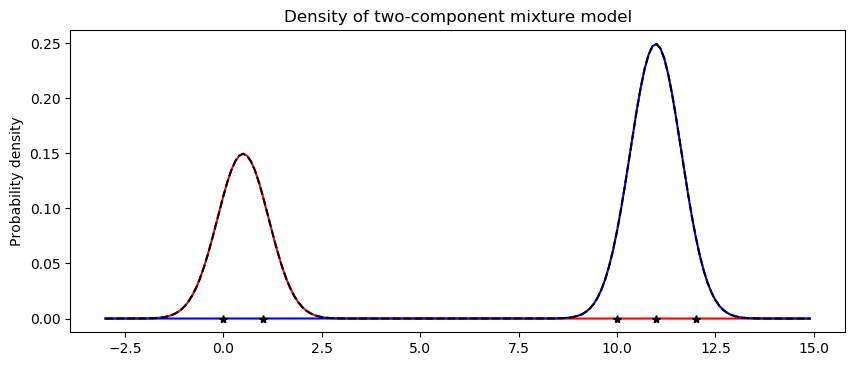

In [11]:
X = np.arange(-3, 15, 0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(X, Y1, 'r-')
plt.plot(X, Y2, 'b-')
plt.plot(X, Y1+Y2, 'k--')
plt.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
plt.title('Density of two-component mixture model')
plt.ylabel('Probability density')

Finally note that optimization with mixture models is non-convex and can often get stuck in local optima. For example in this tutorial, we observe that the mixture model gets stuck in an everything in one cluster hypothesis if `scale` is initialized to be too large.

## Serving the model: predicting membership

Now we've trained a mixture model, we might want to use the model as a classifier. During training we marginalized out the assignment  variables in the model. While this provides fast convergence, it prevents us from reading the cluster assignments from the guide. We'll discuss two options for treating the model as a classifier, first using `infer_discrete` (much faster) and second by training a secondary guide using enumeration inside SVI (slower but more general).

### Predicting membership using discrete inference
The fastest way to predict membership is to use the `infer_discrete` handler, together with `trace` and `replay`. Let's start out with a MAP classifier, setting `infer_discrete`'s temperature parameter to zero. 

In [12]:
guide_trace = poutine.trace(global_guide).get_trace(data) # record the globals
trained_model = poutine.replay(model, trace=guide_trace) # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                   first_available_dim=-2) # to avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]

print(classifier(data))

tensor([0, 0, 1, 1, 1])


Indeed we can run this classifier on new data

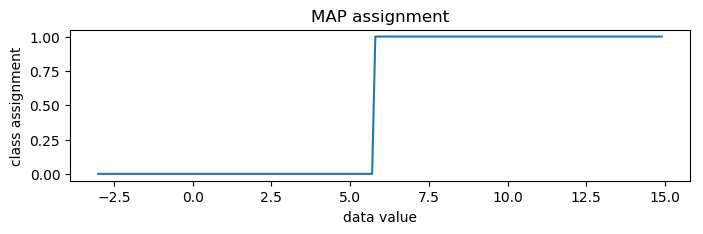

In [13]:
new_data = torch.arange(-3, 15, 0.1)

assignment = classifier(new_data)

plt.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
plt.plot(new_data.numpy(), assignment.numpy())
plt.title('MAP assignment')
plt.xlabel('data value')
plt.ylabel('class assignment');

To generate random posterior assignments rather than MAP assignments, we could set `temperature=1`.

In [14]:
print(classifier(data, temperature=1))

tensor([0, 0, 1, 1, 1])


Since the classes are very well separated, we zoom in to the boundary between classes, around 5.75.

Text(0, 0.5, 'class assignment')

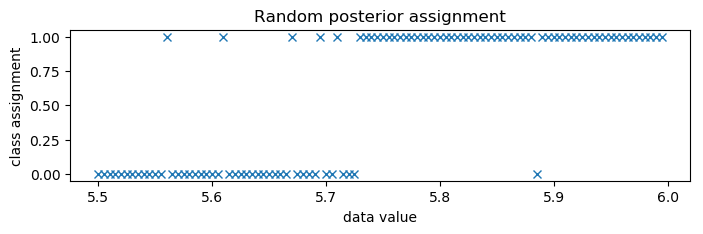

In [15]:
new_data = torch.arange(5.5, 6.0, 0.005)
assignment = classifier(new_data, temperature=1)
plt.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
plt.plot(new_data.numpy(), assignment.numpy(), 'bx', color='C0')
plt.title('Random posterior assignment')
plt.xlabel('data value')
plt.ylabel('class assignment')

### Predicting membership by enumerating the guide

A second way to predict class membership is to enumerate in the guide. This doesn't work well for serving classifier models, since we need to run stochastic optimization for each new input data batch, but it is more general in that it can be embedded in larger variational models.

To read cluster assignments from the guide, we'll define a new `full_guide` that fits both global parameters (as above) and local parameters (which were previously marginalized out). Since we've already learned good values for the global variables, we will block SVI from updating those by using `poutine.block`.\

In [16]:
@config_enumerate
def full_guide(data):
    # Global variables.
    with poutine.block(hide_types=['param']): # Keep our learned values of global parameters
        global_guide(data)
        
    # Local variables
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K,
                                     constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))

In [17]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, full_guide, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, full_guide, data) # Initializes param store
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
    
losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

Text(0.5, 1.0, 'Convergence of SVI')

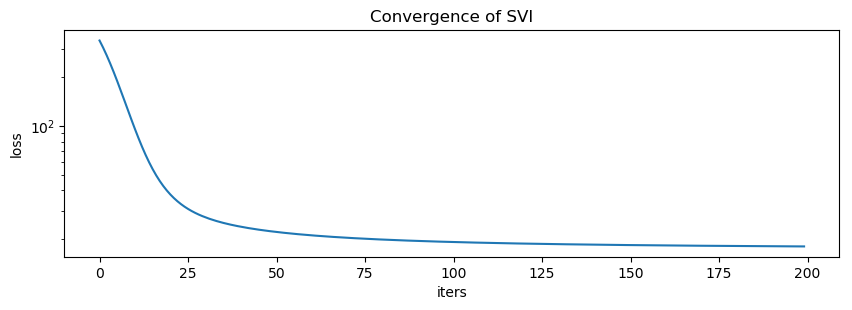

In [18]:
plt.figure(figsize=(10, 3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')

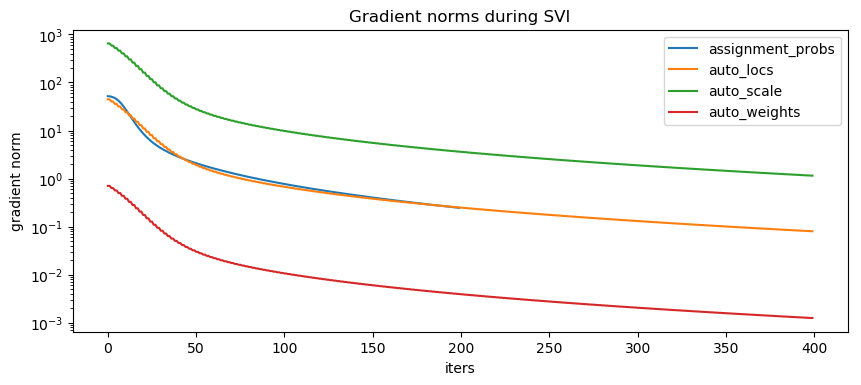

In [19]:
plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    plt.plot(grad_norms, label=name)

plt.xlabel('iters')
plt.ylabel('gradient norm')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Gradient norms during SVI');

We can now examine the guide's local `assignment_probs` variable.

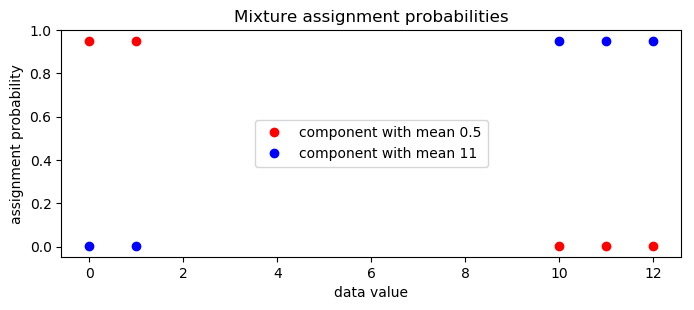

In [20]:
assignment_probs = pyro.param('assignment_probs')
plt.figure(figsize=(8, 3), dpi=100).set_facecolor('white')
plt.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 0], 'ro',
        label='component with mean {:0.2g}'.format(locs[0]))
plt.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 1], 'bo',
        label='component with mean {:0.2g}'.format(locs[1]))
plt.title('Mixture assignment probabilities')
plt.xlabel('data value')
plt.ylabel('assignment probability')
plt.legend(loc='center');